# &#x1F4D6; **作业 9: Part 2 BERT 可解释性**

In [72]:
# from IPython import display
# 可以直接访问 https://exbert.net/exBERT.html
# display.IFrame("https://exbert.net/exBERT.html", width=1600, height=1600)

In [80]:
# !pip install transformers==4.5.0
import os
import numpy as np
import random
import torch

from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from transformers import BertModel, BertTokenizerFast

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 
# 设置台湾字体便于在matplotlib中显示繁体字； 下載台北思源黑体  命名taipei_sans_tc_beta.ttf，移至指定路徑
# !gdown --id '1JWHUSlcPwoEzmr0VE6J71jcnwinH10G6' --output taipei_sans_tc_beta.ttf
# 自定义字体变量
myfont = FontProperties(fname=r'taipei_sans_tc_beta.ttf')
# 后面使用的时候只要 fontproperties=myfont 就可以了
##### 代码参考： https://colab.research.google.com/github/willismax/matplotlib_show_chinese_in_colab/blob/master/matplotlib_show_chinese_in_colab.ipynb #####

plt.rcParams['figure.figsize'] = [12, 10]
# seed 设置已经在前面设置了

In [82]:
# 设置全局的随机种子
def all_seed(seed=6666):
    """
    设置随机种子
    """
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed)
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
    # python 全局
    os.environ['PYTHONHASHSEED'] = str(seed)
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')
all_seed(6666)

Set env random_seed = 6666


## &#x2728; Embedding 可视化 (Q25~27)

#### 我们现在有一个预训练好的模型，并在阅读理解上微调过

阅读理解需要4个步骤：（这些步骤并**不**是按照顺序排列的 ）
- 将类似的文字分群(基于语境中词语的关系)
- 提取答案
- 将类似的文字分群 (根据文字的意思)
- 从文章中寻找与问题有关的信息


#### 你可以在只看见模型`hidden states embedding`的情況下，找出各个layer的功能嗎?

### 下载`Tokenizers` 和模型`Models' hidden states`

### 载入Tokenizers

In [19]:
Tokenizer = BertTokenizerFast.from_pretrained("hw9_bert/tokenizer2")

### What to Visualize?

In [88]:
contexts, questions, answers = [], [], []

# Question 1
contexts += ["Nikola Tesla (Serbian Cyrillic: Никола Тесла; 10 July 1856 – 7 January 1943) was a Serbian American inventor, electrical engineer, \
            mechanical engineer, physicist, and futurist best known for his contributions to the design of the modern alternating current \
            (AC) electricity supply system."]
questions += ["In what year was Nikola Tesla born?"]
answers += ["1856"]

# Question 2
contexts += ['Currently detention is one of the most common punishments in schools in the United States, the UK, Ireland, Singapore and other countries. \
            It requires the pupil to remain in school at a given time in the school day (such as lunch, recess or after school); or even to attend \
            school on a non-school day, e.g. "Saturday detention" held at some schools. During detention, students normally have to sit in a classroom \
            and do work, write lines or a punishment essay, or sit quietly.']
questions += ['What is a common punishment in the UK and Ireland?']
answers += ['detention']

# Question 3
contexts += ['Wolves are afraid of cats. Sheep are afraid of wolves. Mice are afraid of sheep. Gertrude is a mouse. Jessica is a mouse. \
            Emily is a wolf. Cats are afraid of sheep. Winona is a wolf.']
questions += ['What is Emily afraid of?']
answers += ['cats']

### <font color=darkred><b>TODO</font></b>
这是唯一需要修改才能回答的部分 Q25~27.m

In [99]:
# Choose from 1, 2, 3
QUESTION = 3

### 进行可视化
questions[QUESTION-1]：表示从questions列表中获取第QUESTION个问题。

contexts[QUESTION-1]：表示对应问题的上下文。

return_tensors='pt'：指定返回的张量（tensor）格式为PyTorch的pt（即使用PyTorch库）。

In [102]:
# 将问题和段落标记化`Tokenize`并编码为模型的输入格式
inputs = Tokenizer(questions[QUESTION-1], contexts[QUESTION-1], return_tensors='pt') 

# 在`encoded`的序列中获取[question, context] 的 [start, end] 位置
question_start, question_end = 1, inputs['input_ids'][0].tolist().index(102) - 1
context_start, context_end = question_end + 2, len(inputs['input_ids'][0]) - 2

# 长度为13的 tuple, 第一个元素时embedding的输出，后续1-12个元素分别为attention层的输出
outputs_hidden_states = torch.load(f"hw9_bert/output/model2_q{QUESTION}")

C:\Users\91168\AppData\Local\Temp\ipykernel_16036\1405996716.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  outputs_hidden_states = torch.load(f"hw9_bert/output/model2_

 代码目的：
 
这个代码的目标是对 BERT 模型中每一层隐藏状态进行降维（PCA降维），并将每层隐藏状态的 token embeddings 可视化。

每个 token 在降维后的二维空间中以点（scatter）表示。

使用不同颜色和标记来区分问题、上下文、答案等元素。

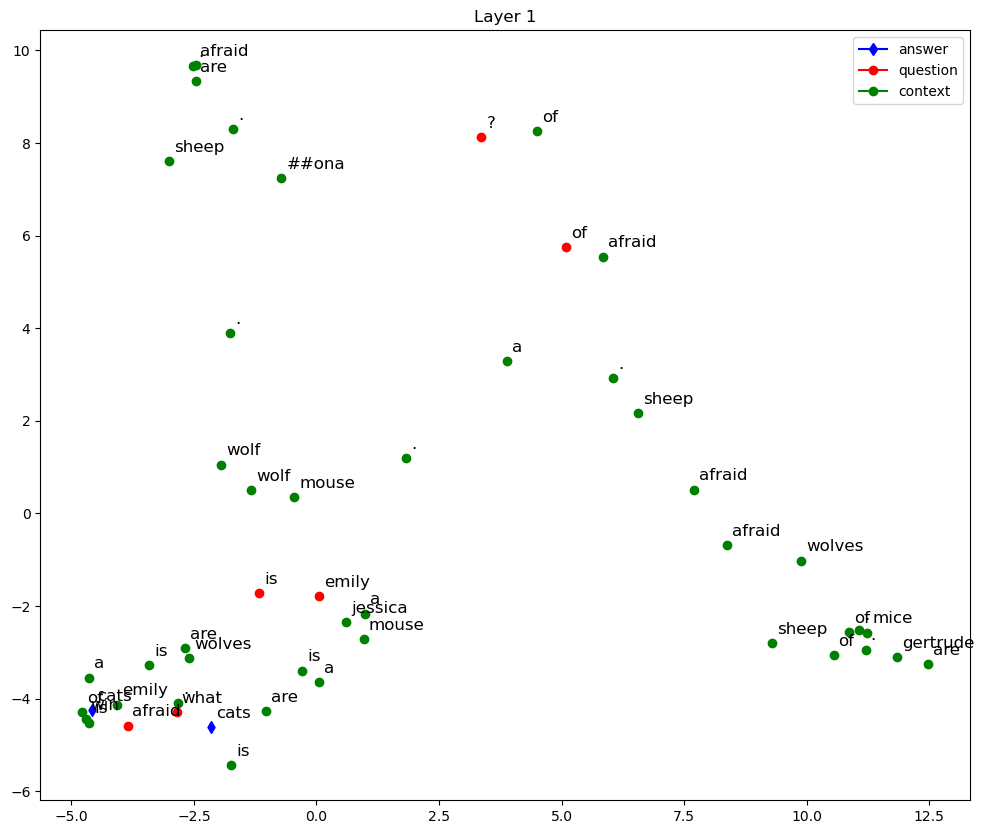

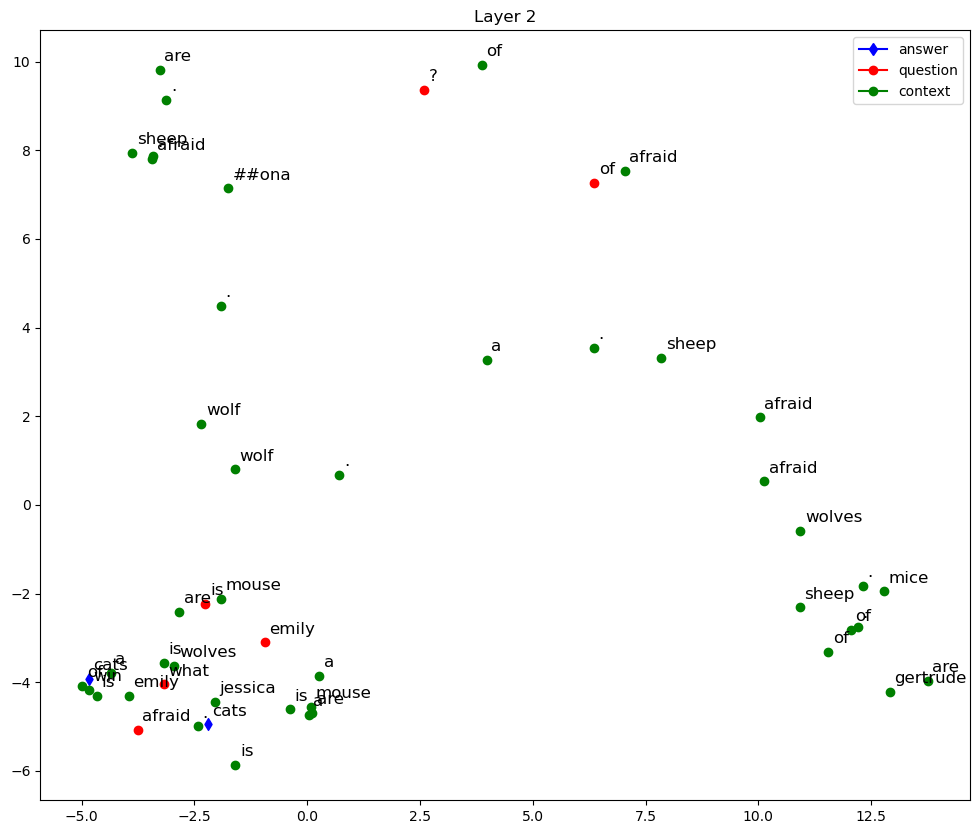

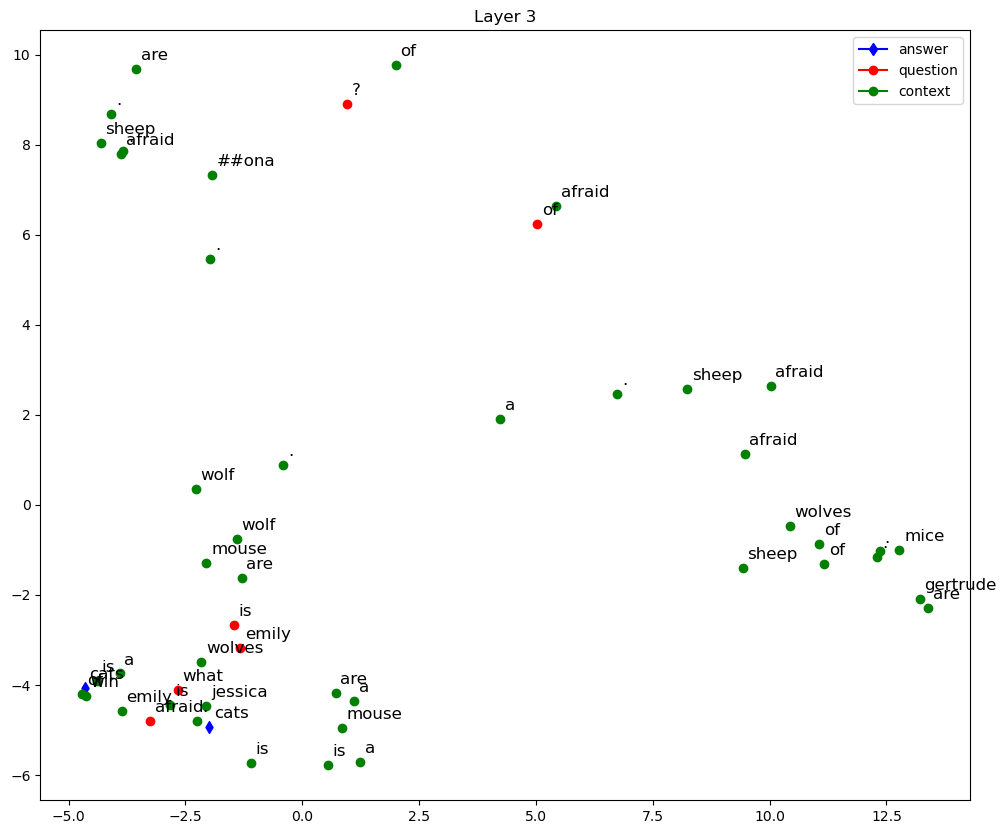

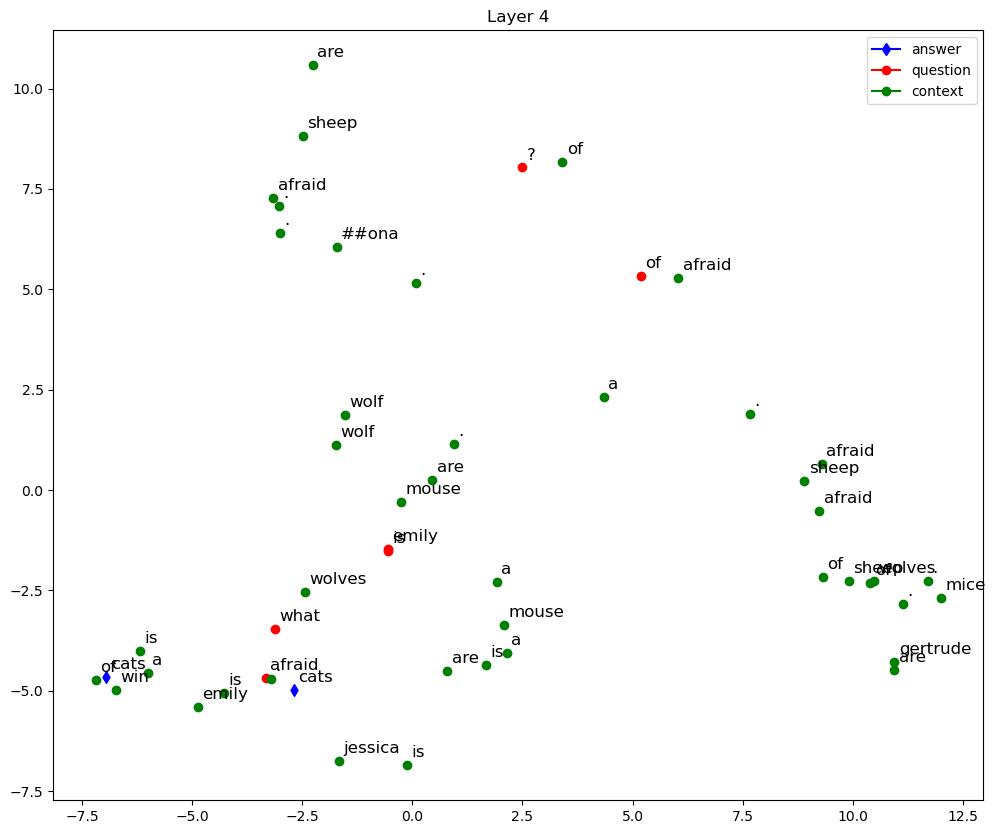

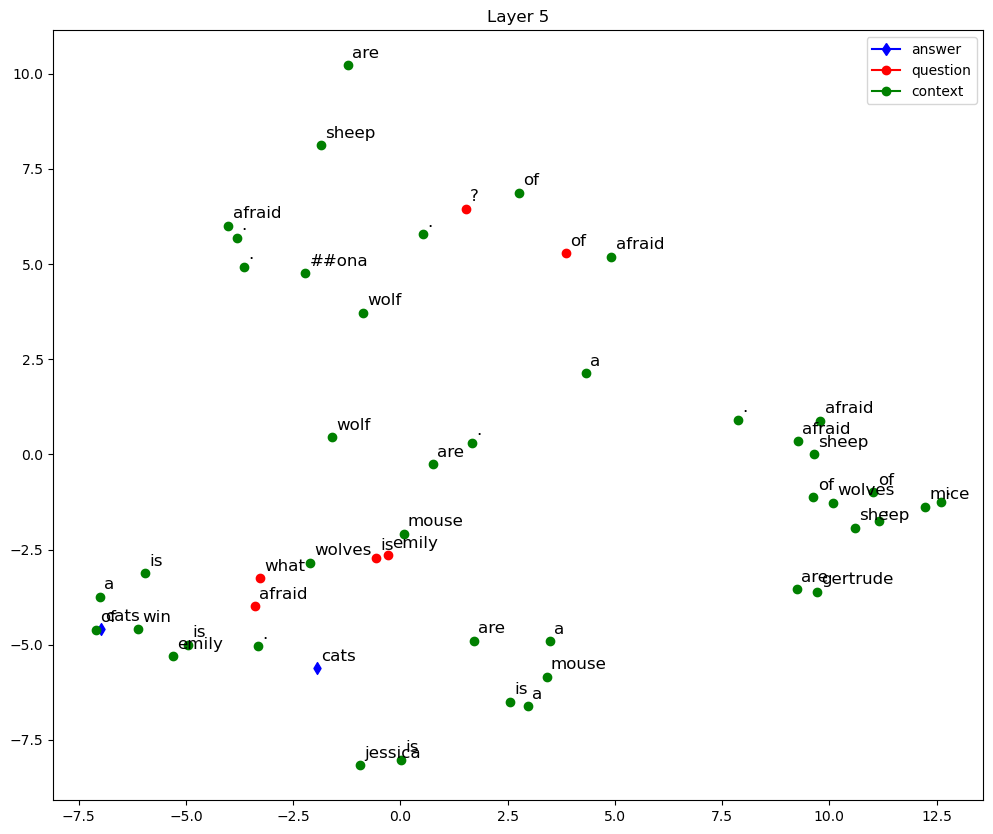

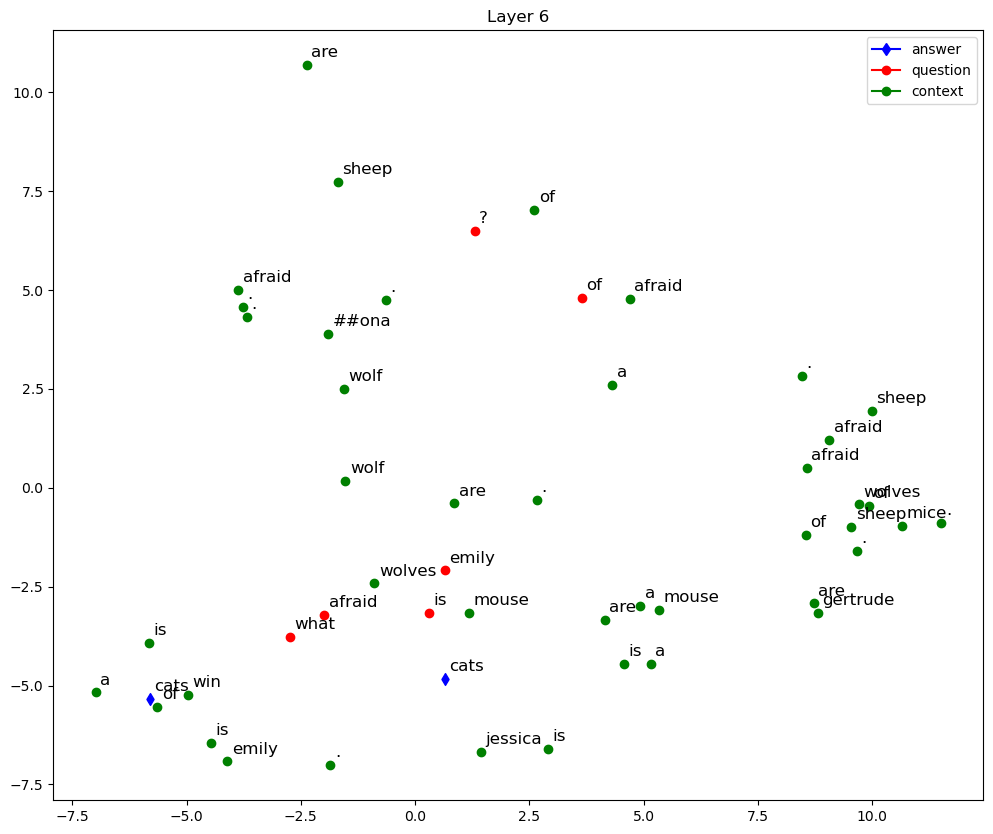

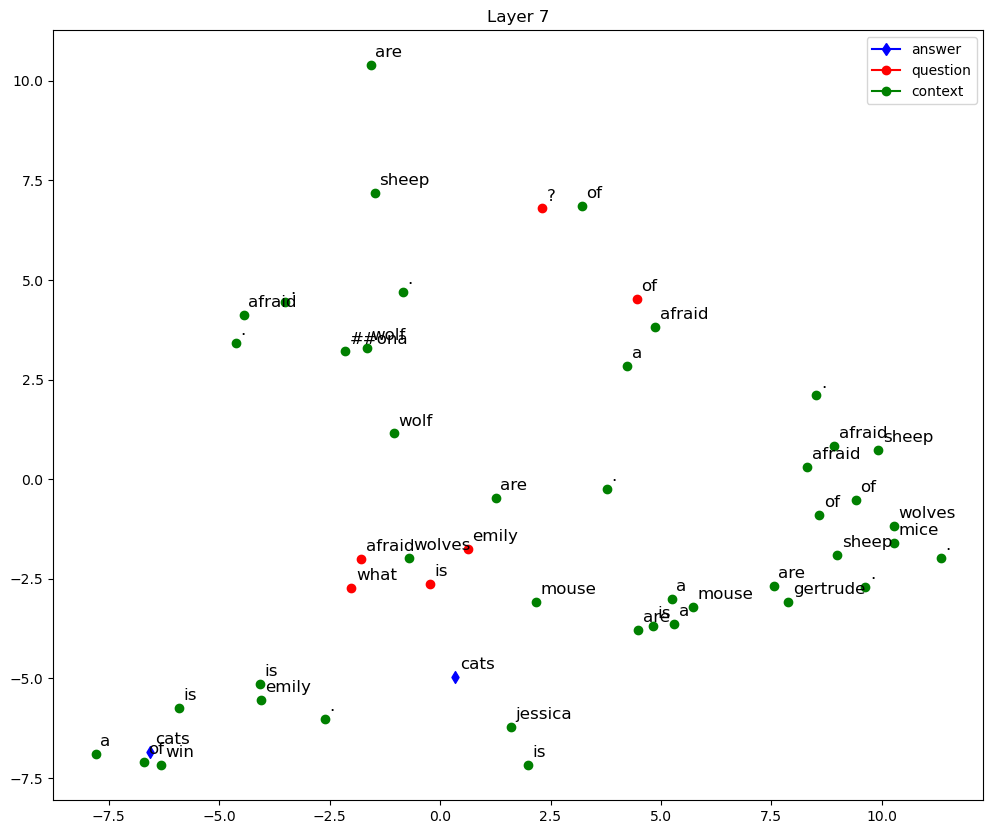

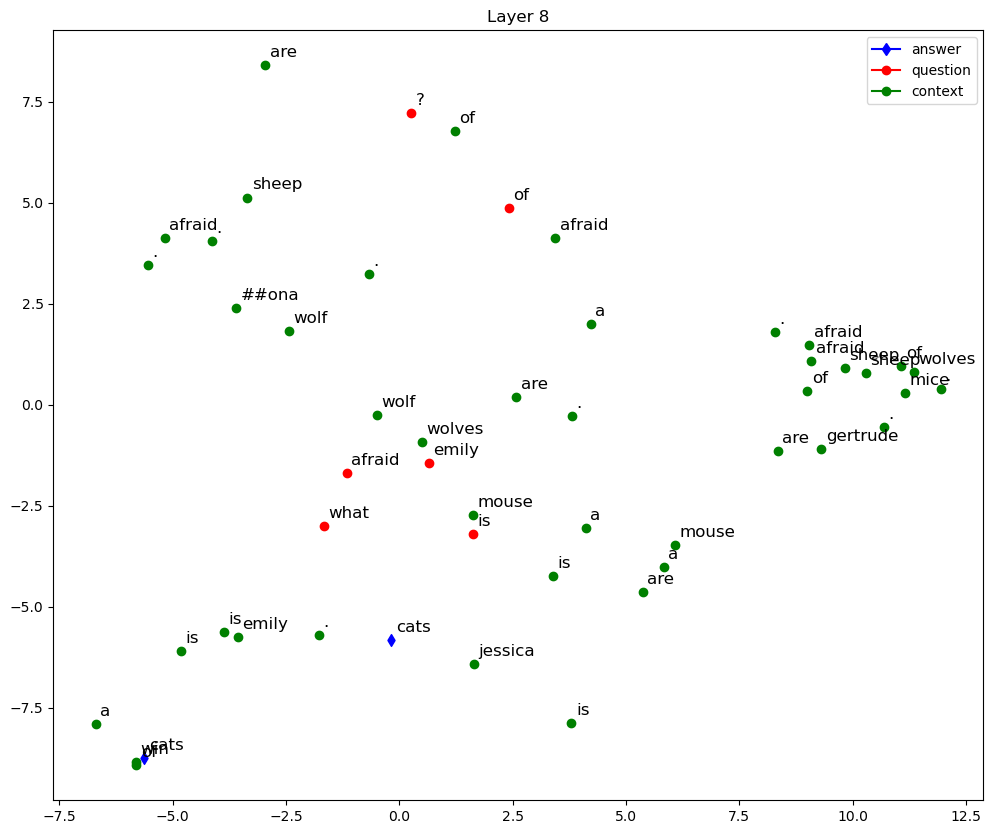

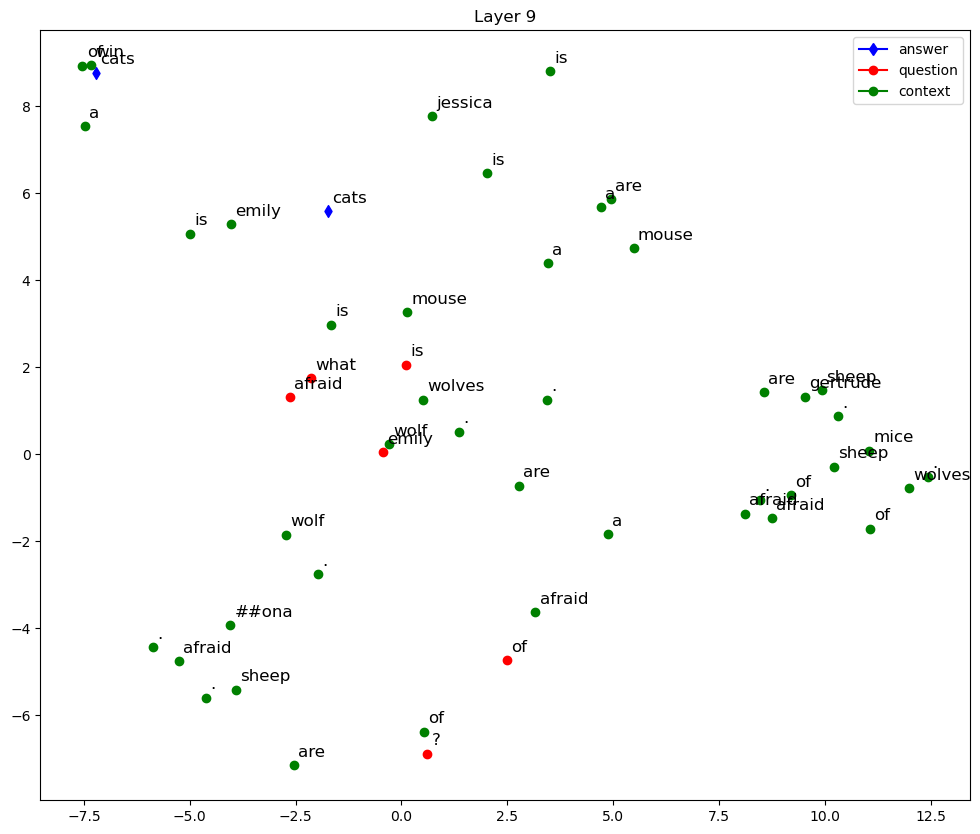

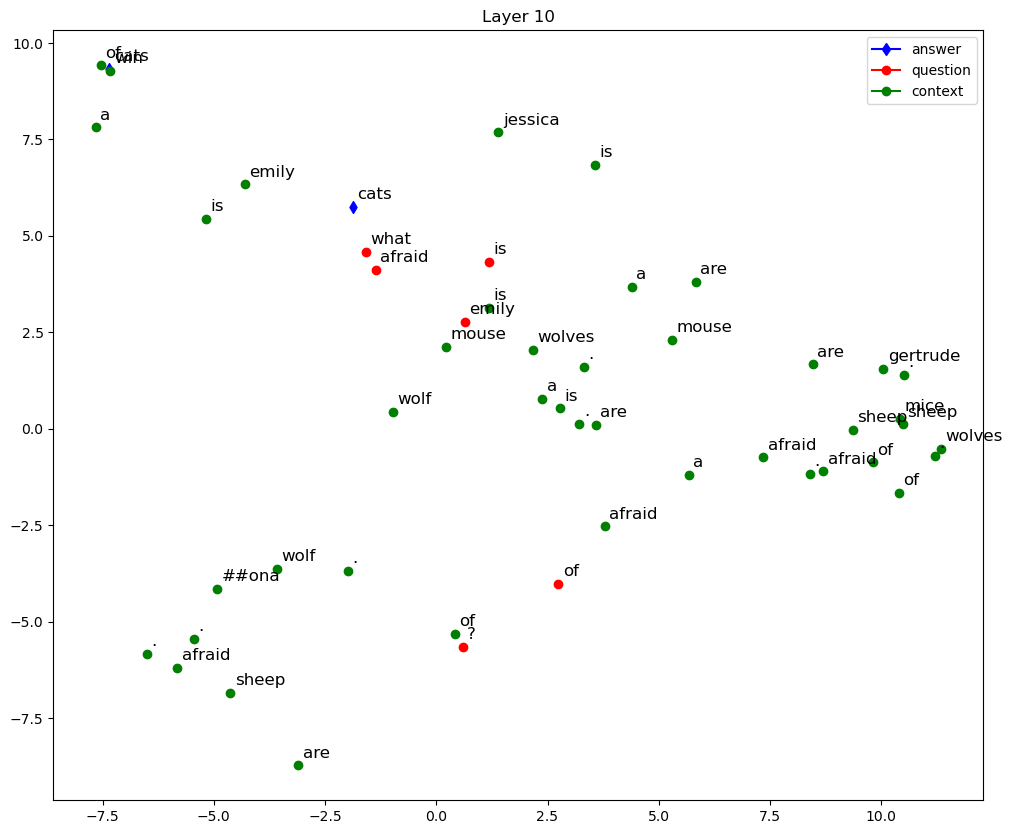

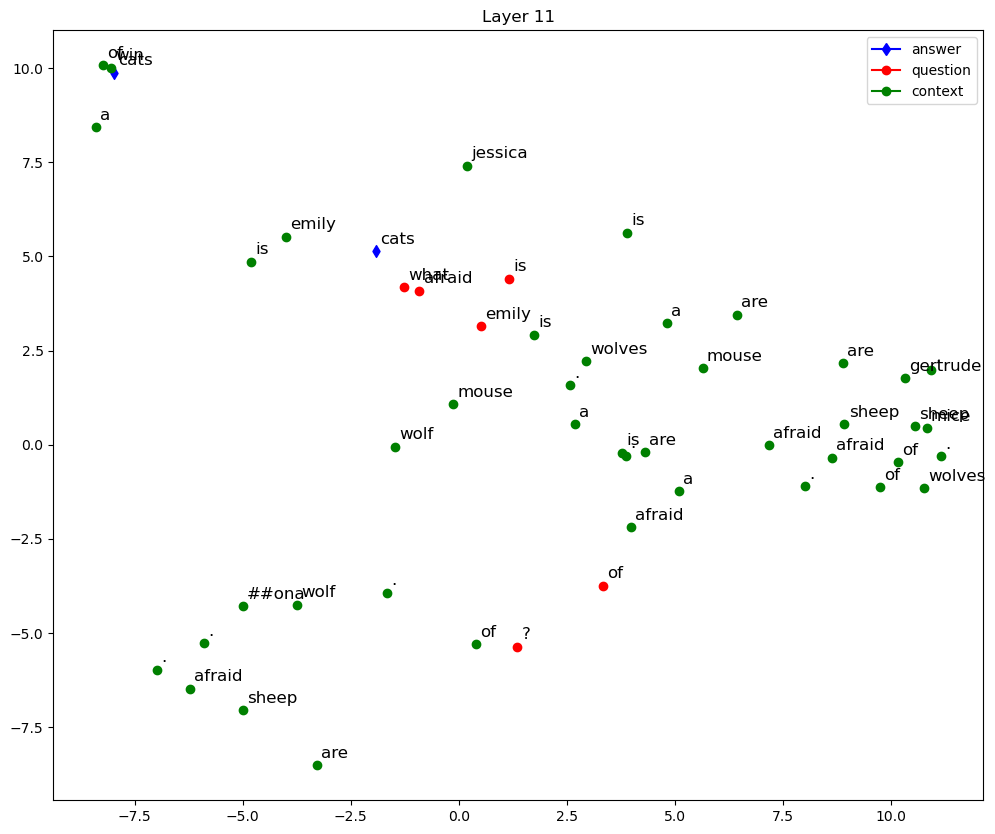

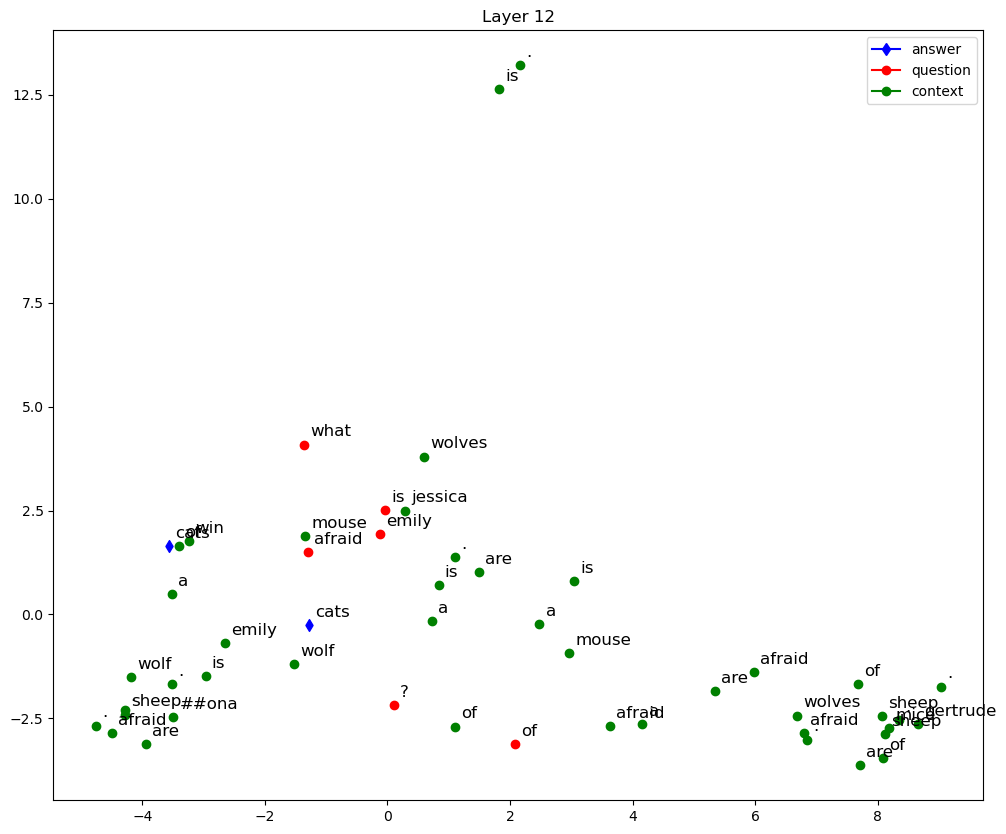

In [105]:
##### 遍历所有层的隐藏状态  #####
for layer_index, embeddings in enumerate(outputs_hidden_states[1:]): # 1st element is skipped
    # "embeddings" -> [1, sequence_length, 768], 768 是 BERT's 隐含层的dim
    # PCA (Principal Component Analysis) 将 "embeddings" 从 768 降维到 2  
    reduced_embeddings = PCA(n_components=2, random_state=0).fit_transform(embeddings[0])

    ##### 将降维后每个token的embedding绘制出来 ##### 
    for i, token_id in enumerate(inputs['input_ids'][0]):
        x, y = reduced_embeddings[i]
        word = Tokenizer.decode(token_id) # 用于标记点 （Decode token back to word）
        # 将 answer, question and context 用不同的颜色标识
        if word in answers[QUESTION-1].split(): # Check if word in answer
            plt.scatter(x, y, color='blue', marker='d') 
        elif question_start <= i <= question_end:
            plt.scatter(x, y, color='red')
        elif context_start <= i <= context_end:
            plt.scatter(x, y, color='green')
        else: # 跳过特殊 tokens [CLS], [SEP]
            continue
        plt.text(x + 0.1, y + 0.2, word, fontsize=12)

    # 绘制空点 便于用legend 标识不同点的代表含义
    plt.plot([], label='answer', color='blue', marker='d')  
    plt.plot([], label='question', color='red', marker='o')
    plt.plot([], label='context', color='green', marker='o')
    plt.legend(loc='best') 
    plt.title('Layer ' + str(layer_index + 1))
    plt.show()

## &#x2728; Embedding 分析(Q28~30)

In [32]:
model = BertModel.from_pretrained('bert-base-chinese', output_hidden_states=True).eval()
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

### What to Visualize?

In [34]:
# 进行可视化的句子
sentences = []
sentences += ["今天買了蘋果來吃"]
sentences += ["進口蘋果（富士)平均每公斤下跌12.3%"]
sentences += ["蘋果茶真難喝"]
sentences += ["老饕都知道智利的蘋果季節即將到來"]
sentences += ["進口蘋果因防止水分流失故添加人工果糖"]
sentences += ["蘋果即將於下月發振新款iPhone"]
sentences += ["蘋果獲新Face ID專利"]
sentences += ["今天買了蘋果手機"]
sentences += ["蘋果的股價又跌了"]
sentences += ["蘋果押寶指紋辨識技術"]

### <font color=darkred><b>TODO</font></b>

这是唯一需要修改才能回答的部分  Q28~30.

In [36]:
# 选择每个句子中的 蘋 字
select_word_index = [4, 2, 0, 8, 2, 0, 0, 4, 0, 0]
# select_word_index = [5, 3, 1, 9, 3, 1, 1, 5, 1, 1]

In [37]:
def euclidean_distance(a, b):
    # 欧式距离
    return np.linalg.norm(a-b,ord=2)

def cosine_similarity(a, b):
    # 余弦相似
    return a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

# 选择评估句子建距离的指标：欧氏距离-euclidean_distance, 余弦距离-cosine_similarity
METRIC = cosine_similarity

# 获取选定单词的嵌入表示
def get_select_embedding(output, tokenized_sentence, select_word_index):
    # 选择进行可视化的层, 0 ~12
    LAYER = 12
    # 获取 layer's hidden state
    hidden_state = output.hidden_states[LAYER][0]
    # 将 select_word_index 通过tokenized 转换后才能 select_token_index 
    select_token_index = tokenized_sentence.word_to_tokens(select_word_index).start
    # 返回选择词的embedding
    return hidden_state[select_token_index].numpy()

### 进行可视化

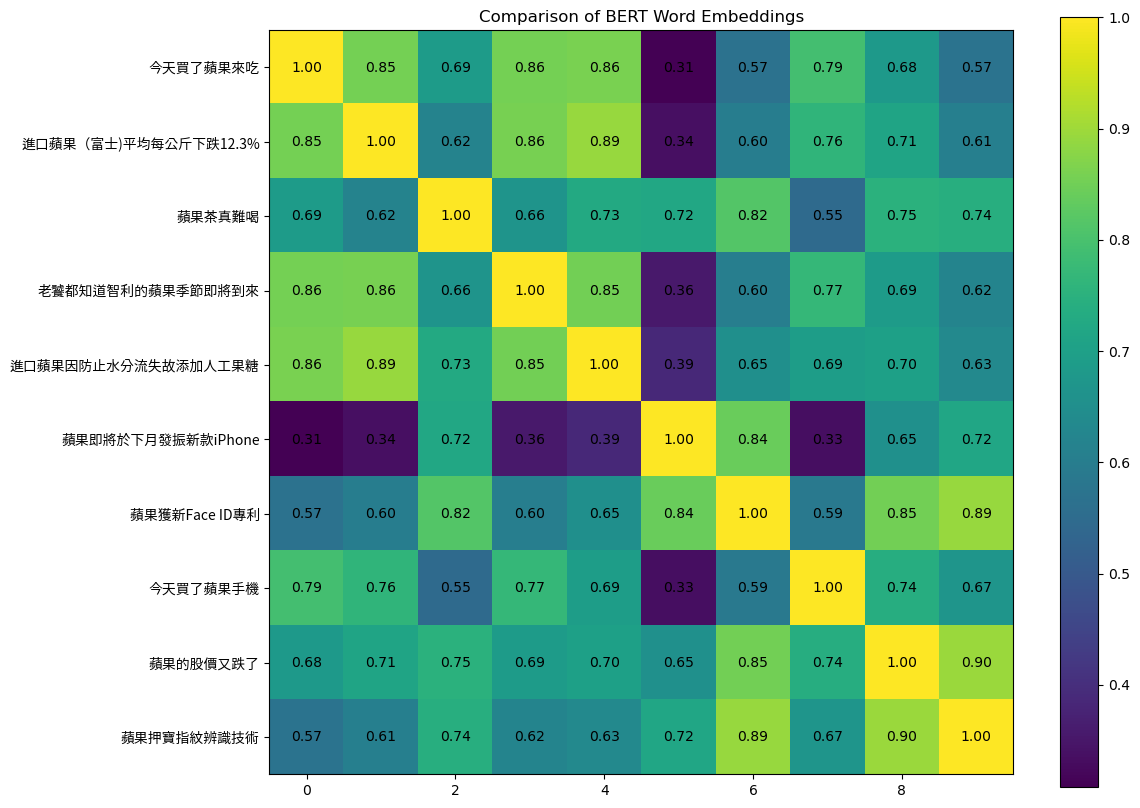

In [39]:
# 将句子标记化（Tokenize）并编码为模型的输入格式
tokenized_sentences = [tokenizer(sentence, return_tensors='pt') for sentence in sentences]

# 获取输出
with torch.no_grad():
    outputs = [model(**tokenized_sentence) for tokenized_sentence in tokenized_sentences]

# 获取选择句子中对应词的embedding. "embeddings" 维度(len(sentences), 768) 768 是 BERT的 hidden state 维度
embeddings = [get_select_embedding(outputs[i], tokenized_sentences[i], select_word_index[i]) for i in range(len(outputs))]

# 对输入进行两量比较 "similarity_matrix" 维度为 [len(sentences), len(sentences)]
similarity_matrix = pairwise_distances(embeddings, metric=METRIC) 

##### 绘制相似矩阵 #####
plt.rcParams['figure.figsize'] = [12, 10] # 设置图像大小
plt.imshow(similarity_matrix) # 绘制相似热力
plt.colorbar()
plt.yticks(ticks=range(len(sentences)), labels=sentences, fontproperties=myfont)  # 使用台湾字体
plt.title('Comparison of BERT Word Embeddings') 
for (i,j), label in np.ndenumerate(similarity_matrix): # np.ndenumerate 是二维版本的 enumerate
    plt.text(i, j, '{:.2f}'.format(label), ha='center', va='center') 
plt.show()  